In [10]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from time import time as timer
from numba import njit

# --- Parameters ---
N = 20000             # Number of superparticles
J = 128               # Grid points

L = 100.0             # Domain size
dx = L / J            # Grid spacing for field quentities
ni = 1.0              # Normalized by reference density N_ref [particles/volume]
weight = ni / (N/L)   # Effective particle number of a superparticle
es = (-1.0) * weight  # (Charge per particle) * (effective particle number)

vb = 3.0              # Beam velocity

# --- Time step control ---
dt = 0.1              # Time step
nt = 800              # Max number of time steps
nskip = 1             # Save every nskip steps
nsave = nt // nskip + 1

# --- Domain arrays ---
xgrid = np.linspace(0, L, J, endpoint=False)
k = fftfreq(J, d=dx) * 2 * np.pi
ksq_inv = np.divide(1.0, k**2, out=np.zeros_like(k), where=k != 0)

# --- Initialization ---
np.random.seed(0)
r_init = np.random.rand(N) * L
# r_init = np.concatenate([
#     np.linspace(0, L, N//2, endpoint=False) + np.random.rand(N//2) * dx,
#     np.linspace(0, L, N//2, endpoint=False) + np.random.rand(N//2) * dx
# ])
v_init = np.concatenate([
    np.random.normal(loc=vb, scale=1.0, size=N//2),
    np.random.normal(loc=-vb, scale=1.0, size=N//2)
])

# --- Assign discrete particles to electron density ne(x) on grid ---
@njit
def deposit_charge_density(r):
    rho = ni * np.ones(J)
    for i in range(N):
        xi = r[i] % L
        j = int(xi / dx)
        w = (xi - j * dx) / dx
        rho[j % J] += (es/dx) * (1 - w)
        rho[(j + 1) % J] += (es/dx) * w
    return rho

# --- Poisson solver using FFT ---
def solve_poisson(rho):
    rho_k = fft(rho) / J
    phi_k = rho_k * ksq_inv
    phi = np.real(ifft(phi_k)) * J
    return phi

# --- Calculate electric field E = - d\phi/dx ---
@njit
def compute_electric_field(phi):
    E = np.zeros_like(phi)
    E[1:-1] = - (phi[2:] - phi[:-2]) / (2 * dx)
    E[0] = - (phi[1] - phi[-1]) / (2 * dx)
    E[-1] = - (phi[0] - phi[-2]) / (2 * dx)
    return E

# --- Linear interpolation of electric field at particle positions ---
@njit
def interpolate_field(r, E):
    Ef = np.zeros(N)
    for i in range(N):
        xi = r[i] % L
        j = int(xi / dx)
        w = (xi - j * dx) / dx
        Ef[i] = (1 - w) * E[j % J] + w * E[(j + 1) % J]
    return Ef

# --- Solve 1D PIC simulation by Leap-frog time integration ---
def compute_1D_PIC_simulation(r_init, v_init):
    t = 0.0
    r = r_init.copy() # Position at t_i
    v = v_init.copy() # Velocity at the half time grid t_{i-1/2}
    rho = deposit_charge_density(r)
    phi = solve_poisson(rho)
    E = compute_electric_field(phi)

    t_all = [t]
    r_all = [r]
    v_all = [v]
    rho_all = [rho]
    phi_all = [phi]
    E_all = [E]
    for _ in range(nsave): # Save every nskip
        for _ in range(nskip):
            v = v + dt * (- interpolate_field(r, E)) # Advance v(t-dt/2) -> v(t+dt/2)
            r = (r + dt * v) % L               # Advance r(t) -> t(t+dt)
            rho = deposit_charge_density(r)    # Update rho(t+dt)
            phi = solve_poisson(rho)           # Update phi(t+dt)
            E = compute_electric_field(phi)    # Update E(t+dt)
            t = t + dt
        t_all.append(t)
        r_all.append(r)
        v_all.append(v)
        rho_all.append(rho)
        phi_all.append(phi)
        E_all.append(E)
    t_all = np.array(t_all)
    r_all = np.array(r_all)
    v_all = np.array(v_all)
    rho_all = np.array(rho_all)
    phi_all = np.array(phi_all)
    E_all = np.array(E_all)
    return t_all, (r_all, v_all), (rho_all, phi_all, E_all)

# --- Run Simulation ---
elt0 = timer()
print("Start 1D PIC simulation.")
time, particle_history, field_history = compute_1D_PIC_simulation(r_init, v_init)
print("Simulation complete.")
elt1 = timer()
print("Elapsed time for simulation [sec]:", elt1 - elt0)
print(time.shape, len(particle_history), len(field_history))

Start 1D PIC simulation.
Simulation complete.
Elapsed time for simulation [sec]: 1.4185328483581543
(802,) 2 3


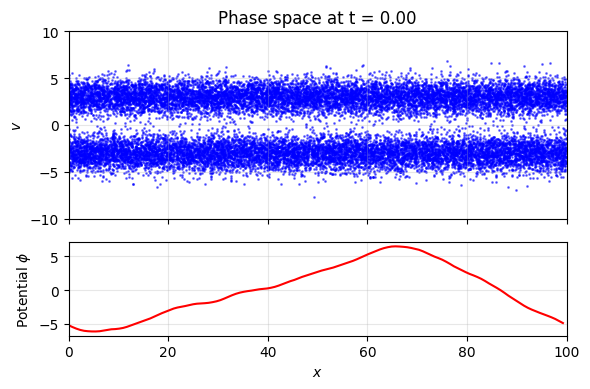

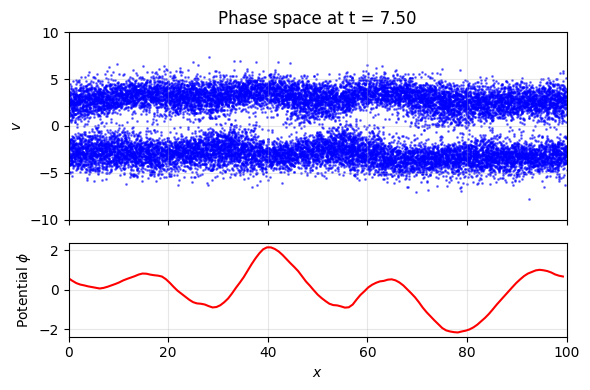

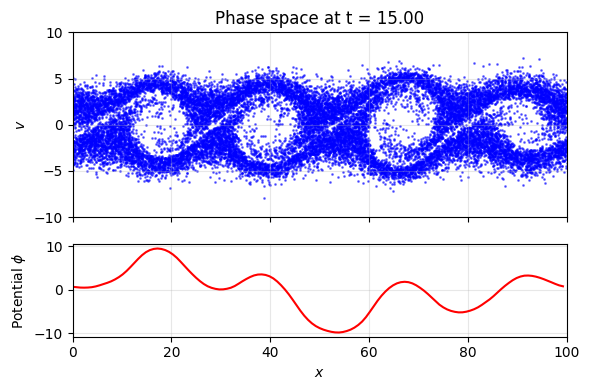

In [11]:
def plot_phase_and_potential(r, v, phi, time_label, L, xgrid):
    """Plot phase space (x, v) and potential phi at a given time."""
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # --- Phase space plot ---
    axs[0].scatter(r, v, s=1, color='b', alpha=0.5)
    axs[0].set_ylabel(r"$v$")
    axs[0].set_ylim(-10, 10)
    axs[0].set_xlim(0, L)
    axs[0].set_title(f"Phase space at t = {time_label:.2f}")
    axs[0].grid(True, alpha=0.3)

    # --- Potential plot ---
    axs[1].plot(xgrid, phi, color='r')
    axs[1].set_ylabel(r"Potential $\phi$")
    axs[1].set_xlim(0, L)
    axs[1].set_xlabel(r"$x$")
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

times_to_plot = [0, 7.5, 15]
for t_plot in times_to_plot:
    idx = np.argmin(np.abs(time - t_plot))
    r = particle_history[0][idx,:]
    v = particle_history[1][idx,:]
    phi = field_history[1][idx,:]
    plot_phase_and_potential(r, v, phi, time[idx], L, xgrid)

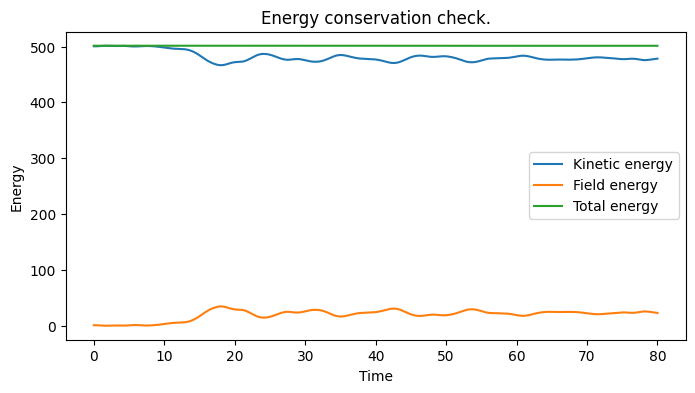

In [6]:
#--- Check energy conservation ---
wtime = time[:-1]              # t =      t_0,   t_1,   t_2, ...,     t_n-2       # t_n-1 is dropped.
v = particle_history[1]         # t = t_-1/2, t_1/2, t_3/2, ..., t_n-5/2, t_n-3/2
wv = 0.5 * (v[1:,:] + v[:-1,:]) # t =      t_0,   t_1,   t_2, ...,     t_n-2       # 2nd-order interpolation
kinetic_energy = np.sum(0.5 * wv**2, axis=1) * weight
field_energy = 0.5 * np.sum(field_history[2][:-1,:]**2, axis=1) * dx
total_energy = kinetic_energy + field_energy

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot ()
ax.plot(wtime, kinetic_energy, label="Kinetic energy")
ax.plot(wtime, field_energy, label="Field energy")
ax.plot(wtime, total_energy, label="Total energy")
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.set_title("Energy conservation check.")
ax.legend()
plt.show()


Elapsed time for animation [sec]: 18.670852184295654


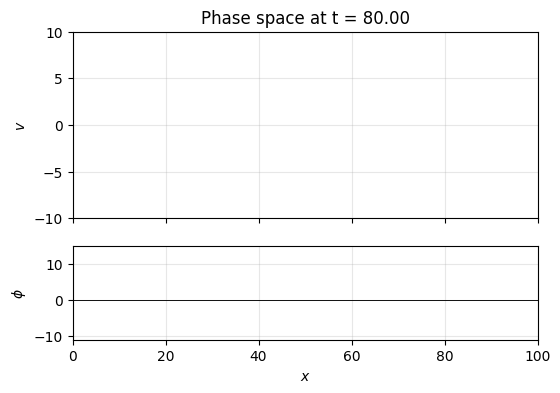

In [12]:
# --- Animation setup ---
frame_skip = 5
Nvis = 2000
vis_idx = np.random.choice(N, Nvis, replace=False)

elt0 = timer()
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Initialize elements ---
scatter = axs[0].scatter([], [], s=1, color='b', alpha=0.5)
line_phi, = axs[1].plot([], [], color='r')

axs[0].set_ylabel(r"$v$")
axs[0].set_ylim(-10, 10)
axs[0].set_xlim(0, L)
axs[0].set_title("Phase space")
axs[1].axhline(0, lw=0.5, c="k")
axs[0].grid(True, alpha=0.3)

axs[1].set_ylabel(r"$\phi$")
phimax = np.max(field_history[1][:,:])
phimin = np.min(field_history[1][:,:])
axs[1].set_ylim(phimin, phimax)
axs[1].set_xlim(0, L)
axs[1].set_xlabel(r"$x$")
axs[1].axhline(0, lw=0.5, c="k")
axs[1].grid(True, alpha=0.3)

def init():
    scatter.set_offsets(np.empty((0, 2)))
    line_phi.set_data([], [])
    return scatter, line_phi

def update(i):
    r = particle_history[0][i,vis_idx]
    v = particle_history[1][i,vis_idx]
    phi = field_history[1][i,:]

    # update scatter
    scatter.set_offsets(np.c_[r, v])
    axs[0].set_title(f"Phase space at t = {time[i]:.2f}")

    # update potential
    line_phi.set_data(xgrid, phi)

    return scatter, line_phi

ani = FuncAnimation(fig, update, frames=range(0, len(time), frame_skip), init_func=init,
                    interval=50, blit=False)

# --- Save animation ---
ani.save("phase_potential_animation.mp4", writer="ffmpeg", fps=20)
elt1 = timer()
print("Elapsed time for animation [sec]:", elt1 - elt0)

# --- Display in notebook ---
Video("phase_potential_animation.mp4", embed=True)